In [1]:
import Pkg
Pkg.activate(dirname(Base.current_project())) # activate project
using DifferentialEquations
using Optimization, OptimizationOptimJL
using Statistics
using Plots

  Activating project at `~/Julia/Julia-intro-for-geoscience-EGU2024`


## Jordi: why I love Julia

- Syntax and expressivity
- Modern and efficient package and environment manager
- Julia is perfect for science
- Great automatic differentiation (AD) support = fancy Scientific Machine Learning capabilities, mixing differential equations with machine learning
- Huge amount of numerical solvers and tools

# Differential equations in Julia

In this third and last notebook, we are going to briefly introduce some of the packages and capabilities of Julia in order to solve and optimize (i.e. forward and inverse) problems including differential equations. We will focus on a simple ODE to illustrate how this works. 

## Solving differential equations

### Lotka-Volterra equations

The Lotka-Volterra equations are used to describe prey-predator dynamics of biological systems. They look like this:

$$
\begin{array}{lcl}
\frac{dx}{dt} = \alpha x - \beta xy, \\ \\
\frac{dy}{dt} = \gamma xy - \delta y,
\end{array}
$$

where 

- $x$ is the population density of prey (e.g. rabbits)
- $y$ is the population density of predator (e.g. wolves)
- $\frac{dx}{dt}$ and $\frac{dy}{dt}$ represent the instantaneous growth rates of both populations
- $\alpha$, $\beta$, $\gamma$ and $\delta$ are parameters modulating the birth and death rates of each population. 

In Julia, we would write this equation like this, following the standard interface of the popular package `DifferentialEquations.jl`:

In [2]:
function lotka_volterra!(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α*u[1] - β*u[2]*u[1] # dx/dt
    du[2] = γ*u[1]*u[2]  - δ*u[2] # dy/dt
end

lotka_volterra! (generic function with 1 method)

In order to easily solve these ODEs, first we need to declare the initial values of our populations and the parameters of the equation:

In [3]:
tspan = (0.0, 20.0) # Time range for the simulation
u₀ = [0.44249296,4.6280594] # Initial values for the x and y populations, respectively
p = [1.3, 0.9, 0.8, 1.8]; # Values for the alpha, beta, gamma and delta parameters, respectively

Then, we can create an `ODEProblem` based on the `lotka_volterra!` function and these parameters, which we can easily solve. In the `solve` function from `DifferentialEquations.jl`, we can specify which solver we'd like to use, or we can let the package decide for us (i.e. using some heuristics). We can also provide relative and absolute tolerances, and we can decide at which timestep to solve the output of the differential equation. 

In [4]:
prob = ODEProblem(lotka_volterra!, u₀, tspan, p)
solution = solve(prob, abstol=1e-12, reltol=1e-12, saveat = 0.1);

Now we can plot the `solution` to see how it looks like.

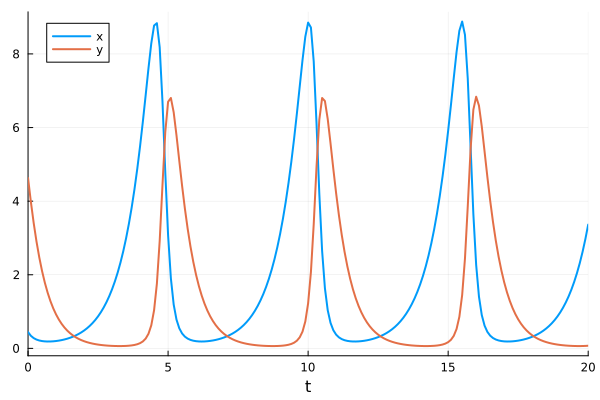

In [5]:
plot(solution, linewidth = 2, label = ["x" "y"])

We can see that as the rabbit ($x$) population grows, at some point the wolve population grows a lot as a consequence of all the available food. This reaches a tipping point, where the rabbit population is too small for the current wolve population, which sees both populations decrease. 

## Optimization with differential equations

Another very interesting aspect of Julia are its automatic differentiation capabilities, which are great for inverse problems and for machine learning. In order to illustrate this, we'll perform some optimization in the Lotka-Volterra equations, in order to invert some unknown parameters.

For this, we will create an objective function based on the `lotka_volterra!` function, for which we will invert two missing parameters.

In [22]:
function lotka_volterra_inference!(du, u, p, known_params, t)
    β, γ = known_params
    # We invert p[1] and p[2]
    du[1] = p[1]*u[1] - β*u[2]*u[1] # dx/dt
    du[2] = γ*u[1]*u[2] - p[2]*u[2] # dy/dt
end

lotka_volterra_inference! (generic function with 1 method)

In [24]:
function objfun(p, known_params, u₀, tspan, real_solution)
    
    lotka_volterra_closure!(du,u,p,t) = lotka_volterra_inference!(du,u,p, known_params,t)
    prob = ODEProblem(lotka_volterra_closure!, u₀, tspan, p)
    solution = solve(prob, p=p, abstol=1e-12, reltol=1e-12, saveat = 0.1)
    
    MSE = mean((solution.u[1] .- real_solution.u[1]).^ 2 .+ (solution.u[2] .- real_solution.u[2]).^ 2)

    return MSE
end

objfun (generic function with 1 method)

Once we have the objective function, we can perform an optimization based on it using the `Optimization.jl` package. We'll use forward differentiation with `ForwardDiff.jl`, since we only have 2 parameter to optimize ($\alpha$ the birth rate of rabbits, and $\delta$ the death rate of wolves). For anything larger than 100 parameters (e.g. neural networks) we'd need to use reverse 
differentation. 

In [25]:
tspan = (0.0, 20.0) # Time range for the simulation
u₀ = [0.44249296,4.6280594] # Initial values for the x and y populations, respectively
known_params = [0.9, 0.8, 1.8] # Values for the known beta, gamma and delta parameters, respectively
real_solution = solution # we use the previously run simulation
objfun_closure(p, known_params) = objfun(p, known_params, u₀, tspan, real_solution)
lotka_volterra_closure!(du,u,p,t) = lotka_volterra_inference!(du,u,p, known_params,t)

optfun = OptimizationFunction(objfun_closure, Optimization.AutoForwardDiff()) 
optprob = OptimizationProblem(optfun, u₀, p) 
optimized_solution = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 1.2999994317047656
 1.800000030435726

If we check the previous values we used in the previous section of this notebook, we can see that we were able to successfully invert the original parameters with high accuracy. 

If we want to know the details of the optimization we can check:

In [21]:
optimized_solution.original

 * Status: success

 * Candidate solution
    Final objective value:     3.042955e-16

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 2.89e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.61e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.30e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.26e+05 ≰ 0.0e+00
    |g(x)|                 = 6.04e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    23
    ∇f(x) calls:   23
